In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import warnings
import gffutils
from tqdm import tqdm
import json

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]


def load_database(db_file, gtf_file):
    if osp.isfile(db_file):
        db = gffutils.FeatureDB(db_file)
    else:
        db = gffutils.create_db(gtf_file, db_file)
    
    return db


def parse_query(line):
    start, end, chrom, table, featuretype = line
    select_from = 'SELECT * FROM {} WHERE'.format(table)
    start_req = 'start >= {}'.format(start)
    end_req = 'end <= {}'.format(end)
    chrom_req = 'seqid = \"chr{}\"'.format(chrom)
    feature_req = 'featuretype = \"{}\"'.format(featuretype)
    where_reqs = ' AND '.join([start_req, end_req, chrom_req, feature_req])
    query = ' '.join([select_from, where_reqs])
    
    return query


def generate_query(regions, chrom, table='features', featuretype='gene'):
    regions['chrom'] = chrom
    regions['table'] = table
    regions['featuretype'] = featuretype
    reqs = regions.apply(parse_query, 1)

    return reqs


def merge_attr(attrs):
    return {k: [attr[k][0] if k in attr else None for attr in attrs] for k in attrs[0].keys()}


def check_attr(attr, restrictions):
    restrictions = restrictions.strip().split()
    for restr in restrictions:
        k, v = restr.strip().split('=')
        if attr[k][0] != v: return False
        
    return True


def db_query(db, queries, restrictions=None):
    chrom, start, end = [], [], []
    attributes = []
    for query in tqdm(queries):
        itr = db.execute(query).fetchall()
        for obj in itr:
            attr = json.loads(obj['attributes'])
            if restrictions is not None:
                if not check_attr(attr, restrictions): continue
            chrom.append(obj['seqid'])
            start.append(obj['start'])
            end.append(obj['end'])
            attributes.append(attr)
    info = pd.DataFrame({
        'chrom': chrom,
        'start': start,
        'end': end
    })
    attrs = pd.DataFrame(merge_attr(attributes))
    
    return pd.concat([info, attrs], axis=1)

In [30]:
def topdom(pred_mat, window_size=10, cutoff=None):
    if pred_mat.shape[0]-pred_mat.shape[1]:
        raise ValueError(
            'Dimension mismatch ({}, {})'.format(pred_mat.shape[0], pred_mat.shape[1])
        )
    pad_mat = np.pad(pred_mat, window_size, mode='constant', constant_values=np.nan)
    dim = pad_mat.shape[0]
    signal = np.array([
        np.nanmean(pad_mat[i-window_size:i, i:i+window_size]) for i in range(dim)
    ][window_size+1: -window_size])
    if cutoff is not None:
        signal[signal<cutoff] = -1

    return signal


def interpolate(signal, bin_size=10000, pattern='smooth'):
    if pattern is None: return signal
    if pattern not in ['smooth', 'zigzag']:
        raise ValueError(
            'Bad parameter, expecting \'smooth\' or \'zigzag\' but got \'{}\''.format(pattern)
        )
    if pattern=='smooth':
        l = len(signal) * bin_size
        sparse, compact = np.linspace(0, l, len(signal)), np.linspace(0, l, l)
        interp_signal = np.interp(compact, sparse, signal)
    else:
        interp_signal = np.tile(signal, (bin_size, 1)).flatten('F')
    
    return interp_signal


def similarity(signal1, signal2, window_size=100):
    if len(signal1)-len(signal2):
        raise ValueError(
            'Different signal1.length ({}) and signal2.length ({})'.format(len(signal1), len(signal2))
        )
    l = len(signal1)
    score = np.array([
        scipy.stats.pearsonr(
            signal1[i:i+window_size], signal2[i:i+window_size]
        )[0] for i in range(l-window_size)
    ])
    score[np.isnan(score)] = 1

    return score


def threshold(score, cutoff=0.7, margin=10000):
    indices = np.argwhere(score < cutoff).flatten()
    starts, ends = [], []
    s, e = 0, 0
    for i in tqdm(indices):
        if not s and not e: s, e = i, i
        else:
            if i - e <= margin: e = i
            else:
                starts.append(s)
                ends.append(e)
                s, e = i, i
    if e != ends[-1]:
        starts.append(s)
        ends.append(e)
    regions = pd.DataFrame({
        'start': np.array(starts) - margin,
        'end': np.array(ends) + margin
    })
    return regions

In [76]:
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
gtf_file = '/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.gtf'
db_file = '/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.db'
ct1 = 'mycGCB_am_gfp_myc_gcb_thelp_sample'
ct2 = 'mycGCB_am_gfp_myc_gcb_nothelp_sample'
chrom = 13
osp.join(pred_dir, ct1), osp.join(pred_dir, ct2)

('/data/leslie/suny4/predictions/chromafold/mycGCB_am_gfp_myc_gcb_thelp_sample',
 '/data/leslie/suny4/predictions/chromafold/mycGCB_am_gfp_myc_gcb_nothelp_sample')

In [77]:
%%time

pred1, pred2 = load_pred(pred_dir, ct1, chrom), load_pred(pred_dir, ct2, chrom)

CPU times: user 1.49 s, sys: 1.49 s, total: 2.98 s
Wall time: 3.02 s


In [89]:
%%time

signal1, signal2 = topdom(pred1, window_size=10, cutoff=0), topdom(pred2, window_size=10, cutoff=0)

CPU times: user 1.04 s, sys: 245 ms, total: 1.29 s
Wall time: 1.29 s


In [90]:
%%time

raw_simscore = similarity(signal1, signal2, window_size=100)
simscore = interpolate(raw_simscore, pattern='smooth')

CPU times: user 1.1 s, sys: 217 ms, total: 1.31 s
Wall time: 1.31 s


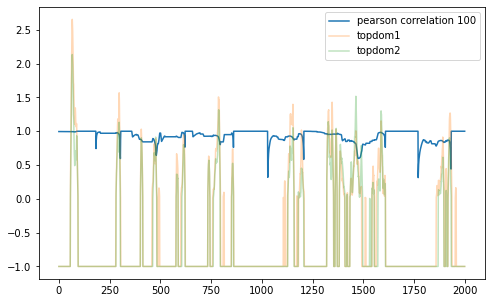

In [91]:
plt.figure(figsize=(8,5))
plt.plot(similarity(signal1, signal2, window_size=100)[3000:5000], label='pearson correlation 100')
plt.plot(signal1[3000:5000], label='topdom1', alpha=0.3)
plt.plot(signal2[3000:5000], label='topdom2', alpha=0.3)
plt.legend()
plt.show()

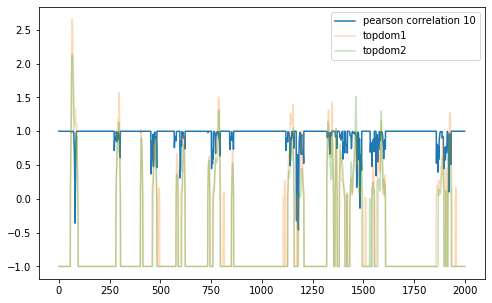

In [92]:
plt.figure(figsize=(8,5))
plt.plot(similarity(signal1, signal2, window_size=10)[3000:5000], label='pearson correlation 10')
plt.plot(signal1[3000:5000], label='topdom1', alpha=0.3)
plt.plot(signal2[3000:5000], label='topdom2', alpha=0.3)
plt.legend()
plt.show()

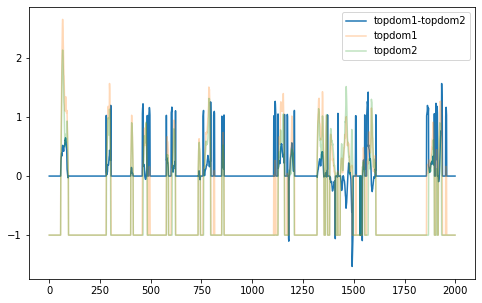

In [93]:
plt.figure(figsize=(8,5))
plt.plot((signal1-signal2)[3000:5000], label='topdom1-topdom2')
plt.plot(signal1[3000:5000], label='topdom1', alpha=0.3)
plt.plot(signal2[3000:5000], label='topdom2', alpha=0.3)
plt.legend()
plt.show()

In [99]:
%%time

regions = threshold(simscore)
queries = generate_query(regions, chrom=chrom, table='features', featuretype='gene')

100%|██████████| 7626004/7626004 [00:03<00:00, 1921407.67it/s]

CPU times: user 4.52 s, sys: 152 ms, total: 4.67 s
Wall time: 4.64 s


In [13]:
db = load_database(db_file, gtf_file)
print(db.schema())

CREATE TABLE features (
    id text,
    seqid text,
    source text,
    featuretype text,
    start int,
    end int,
    score text,
    strand text,
    frame text,
    attributes text,
    extra text,
    bin int,
    primary key (id)
    )
CREATE TABLE relations (
    parent text,
    child text,
    level int,
    primary key (parent, child, level)
    )
CREATE TABLE meta (
    dialect text,
    version text
    )
CREATE TABLE directives (
    directive text
    )
CREATE TABLE autoincrements (
    base text,
    n int,
    primary key (base)
    )
CREATE TABLE duplicates (
    idspecid text,
    newid text,
    primary key (newid)
    )
CREATE INDEX relationsparent ON relations (parent)
CREATE INDEX relationschild ON relations (child)
CREATE INDEX featuretype ON features (featuretype)
CREATE INDEX seqidstartend ON features (seqid, start, end)
CREATE INDEX seqidstartendstrand ON features (seqid, start, end, strand)
CREATE TABLE sqlite_stat1(tbl,idx,stat)


In [92]:
res = db_query(db, queries, restrictions='gene_type=protein_coding')

100%|██████████| 29/29 [00:00<00:00, 162.67it/s]


In [93]:
res

,chrom,start,end,gene_id,gene_type,gene_status,gene_name,level,havana_gene
0,chr1,10024601,10038168,ENSMUSG00000025917.9,protein_coding,KNOWN,Cops5,2,OTTMUSG00000029459.3
1,chr1,23844846,23922317,ENSMUSG00000026155.13,protein_coding,KNOWN,Smap1,2,OTTMUSG00000026521.4
2,chr1,38793645,38836711,ENSMUSG00000048814.10,protein_coding,KNOWN,Lonrf2,2,OTTMUSG00000026560.4
3,chr1,38863867,38898161,ENSMUSG00000026080.13,protein_coding,KNOWN,Chst10,2,OTTMUSG00000049487.3
4,chr1,40074079,40125231,ENSMUSG00000026073.13,protein_coding,KNOWN,Il1r2,2,OTTMUSG00000050443.3
...,...,...,...,...,...,...,...,...,...
64,chr1,177983423,178172704,ENSMUSG00000091476.6,protein_coding,KNOWN,Gm16432,2,OTTMUSG00000050375.1
65,chr1,178187417,178257301,ENSMUSG00000026502.13,protein_coding,KNOWN,Desi2,2,OTTMUSG00000029657.5
66,chr1,178319130,178322693,ENSMUSG00000026500.6,protein_coding,KNOWN,Cox20,2,OTTMUSG00000022143.1
67,chr1,178321108,178337797,ENSMUSG00000039630.10,protein_coding,KNOWN,Hnrnpu,2,OTTMUSG00000021881.3
